In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import chardet  # Detect encoding

In [2]:
# get data
with open('data/data.csv', 'rb') as file:
    result = chardet.detect(file.read())
    encoding = result['encoding']

df = pd.read_csv('data/data.csv',encoding = encoding,low_memory = False)

# fix column names
df.columns = df.columns.str.replace(" ", "")
df.columns = df.columns.str.replace("/", "")
df.columns = df.columns.str.replace("SalePriceperUnit", "SalePricePerUnit")
print(f"Shape of the dataframe: {df.shape}")
df.head()

Shape of the dataframe: (14913, 8)


,#,SchemeName,NetAssetValue,OutstandingNumberofUnits,NavPerUnit,SalePricePerUnit,RepurchasePriceUnit,DateValued
0,1,Umoja Fund,"397,788,850,422.5010","331,528,811.5353","1,199.8621","1,199.8621","1,187.8635",15-07-2025
1,2,Wekeza Maisha Fund,"24,767,597,644.6848","23,412,374.5720","1,057.8849","1,057.8849","1,036.7272",15-07-2025
2,3,Watoto Fund,"32,590,371,554.8241","41,685,206.8298",781.8210,781.8210,774.0028,15-07-2025
3,4,Jikimu Fund,"39,639,788,661.7014","207,241,732.4408",191.2732,191.2732,187.4477,15-07-2025
4,5,Liquid Fund,"1,921,808,923,001.7900","4,126,267,318.1562",465.7500,465.7500,465.7500,15-07-2025


In [3]:
# a function to clean numbers
def clean_numeric_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            # Remove commas and whitespace
            cleaned = df[col].str.replace(',', '', regex=True).str.strip()
            # Attempt conversion to numeric
            converted = pd.to_numeric(cleaned, errors='coerce')
            # If conversion yields valid numbers, replace the column
            if converted.notna().sum() > 0:
                df[col] = converted
    return df

In [4]:
# Apply data cleaning
df = clean_numeric_columns(df)
df = df.astype({'SalePricePerUnit': float, 'RepurchasePriceUnit': float, 'OutstandingNumberofUnits':float, 'NetAssetValue':float})

df['DateValued'] = pd.to_datetime(df['DateValued'], dayfirst=True, errors='coerce') # fix bad dates
df.head()

,#,SchemeName,NetAssetValue,OutstandingNumberofUnits,NavPerUnit,SalePricePerUnit,RepurchasePriceUnit,DateValued
0,1,Umoja Fund,3.977889e+11,3.315288e+08,1199.8621,1199.8621,1187.8635,2025-07-15
1,2,Wekeza Maisha Fund,2.476760e+10,2.341237e+07,1057.8849,1057.8849,1036.7272,2025-07-15
2,3,Watoto Fund,3.259037e+10,4.168521e+07,781.8210,781.8210,774.0028,2025-07-15
3,4,Jikimu Fund,3.963979e+10,2.072417e+08,191.2732,191.2732,187.4477,2025-07-15
4,5,Liquid Fund,1.921809e+12,4.126267e+09,465.7500,465.7500,465.7500,2025-07-15


In [5]:
df = df.dropna(subset=["DateValued", "NetAssetValue"])                              # drop bad dates and NAV
df.shape

(14913, 8)

In [8]:
# Calcualte profit
df["Profit"] = df["SalePricePerUnit"] - df["RepurchasePriceUnit"]
df["ProfitMargin"] = (df["Profit"] / df["SalePricePerUnit"]) * 100

# Group by SchemeName and calculate average profit margin
avg_profit_margin = df.groupby("SchemeName")["ProfitMargin"].mean().sort_values(ascending=False)

df.head()

,#,SchemeName,NetAssetValue,OutstandingNumberofUnits,NavPerUnit,SalePricePerUnit,RepurchasePriceUnit,DateValued,Profit,ProfitMargin
0,1,Umoja Fund,3.977889e+11,3.315288e+08,1199.8621,1199.8621,1187.8635,2025-07-15,11.9986,0.999998
1,2,Wekeza Maisha Fund,2.476760e+10,2.341237e+07,1057.8849,1057.8849,1036.7272,2025-07-15,21.1577,2.000000
2,3,Watoto Fund,3.259037e+10,4.168521e+07,781.8210,781.8210,774.0028,2025-07-15,7.8182,0.999999
3,4,Jikimu Fund,3.963979e+10,2.072417e+08,191.2732,191.2732,187.4477,2025-07-15,3.8255,2.000019
4,5,Liquid Fund,1.921809e+12,4.126267e+09,465.7500,465.7500,465.7500,2025-07-15,0.0000,0.000000


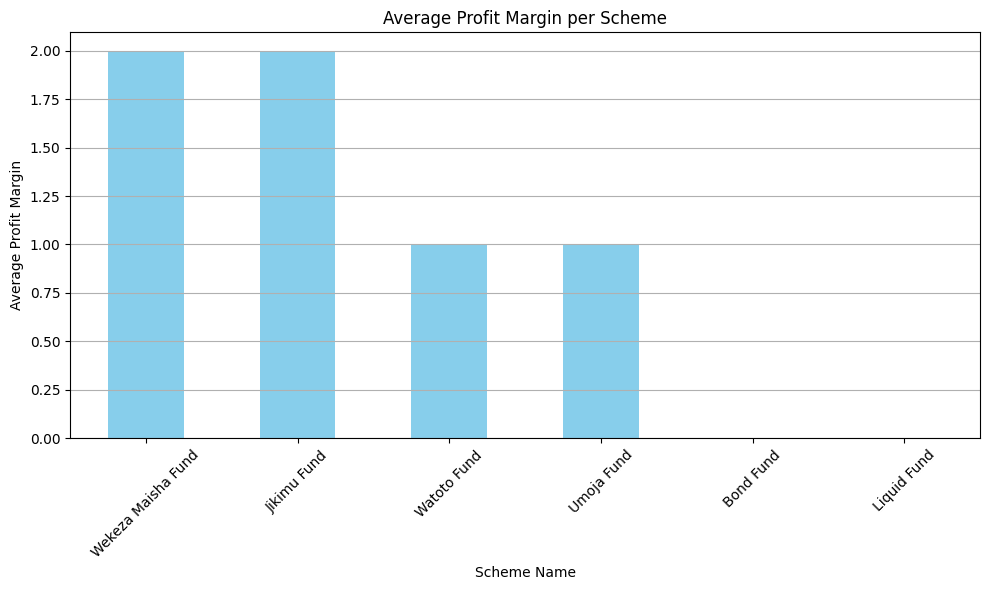

In [7]:

# Plot the average profit margin per scheme
plt.figure(figsize=(10, 6))
avg_profit_margin.plot(kind='bar', color='skyblue')
plt.title("Average Profit Margin per Scheme")
plt.xlabel("Scheme Name")
plt.ylabel("Average Profit Margin")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [117]:
df['SchemeName'].value_counts()

SchemeName
Jikimu Fund           2722
Wekeza Maisha Fund    2718
Umoja Fund            2714
Liquid Fund           2709
Watoto Fund           2707
Bond Fund             1343
Name: count, dtype: int64

In [118]:
# keep a copy
df2 = df.copy()

In [123]:
# return the copy
df = df2.copy()

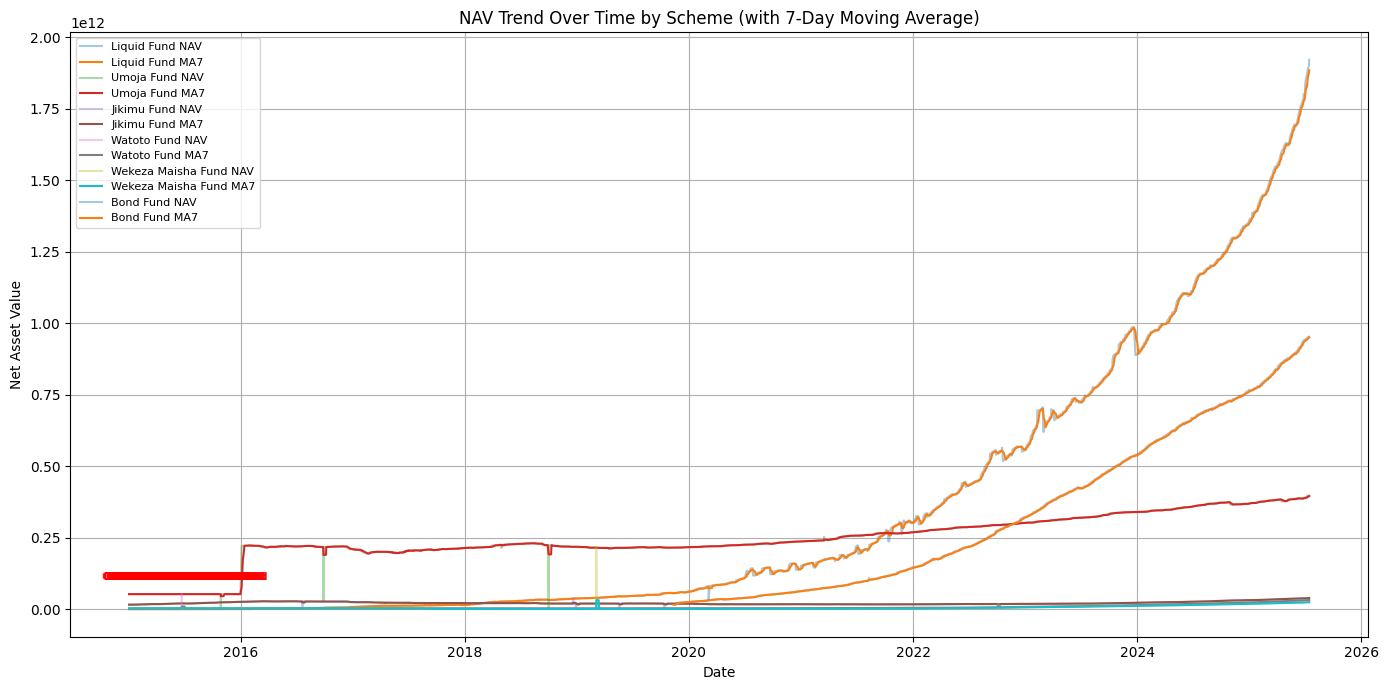

In [128]:
# Plot NAV trend


df = df.sort_values("DateValued").reset_index(drop=True)# Sort by date


# df = df[df["DateValued"] >= "2020-01-01"]


# Identify outliers before 2016
pre_2016 = df[df["DateValued"] < "2016-01-01"]
q1 = pre_2016["NetAssetValue"].quantile(0.25)
q3 = pre_2016["NetAssetValue"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

# Option 1
# Cap outliers to upper bound
df.loc[(df["DateValued"] < "2016-01-01") & (df["NetAssetValue"] > upper_bound), "NetAssetValue"] = upper_bound


# # Option 2
# # Replace outliers with mean of previous and next values
# outlier_indices = df[(df["DateValued"] < "2016-01-01") & (df["NetAssetValue"] > upper_bound)].index

# for idx in outlier_indices:
#     if idx > 0 and idx < len(df) - 1:
#         prev_val = df.loc[idx - 1, "NetAssetValue"]
#         next_val = df.loc[idx + 1, "NetAssetValue"]
#         if pd.notna(prev_val) and pd.notna(next_val):
#             df.loc[idx, "NetAssetValue"] = (prev_val + next_val) / 2



# Create a 7-day moving average per scheme
df["NAV_MA7"] = df.groupby("SchemeName")["NetAssetValue"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


# Plot NAV trend and moving average
plt.figure(figsize=(14, 7))
for scheme in df["SchemeName"].unique():
    scheme_data = df[df["SchemeName"] == scheme]
    plt.plot(scheme_data["DateValued"], scheme_data["NetAssetValue"], label=f"{scheme} NAV", alpha=0.4)
    plt.plot(scheme_data["DateValued"], scheme_data["NAV_MA7"], label=f"{scheme} MA7")


# Annotate corrected outliers
corrected_points = df[(df["DateValued"] < "2016-01-01") & (df["NetAssetValue"] == upper_bound)]
for _, row in corrected_points.iterrows():
    plt.annotate("Corrected", (row["DateValued"], row["NetAssetValue"]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.title("NAV Trend Over Time by Scheme (with 7-Day Moving Average)")
plt.xlabel("Date")
plt.ylabel("Net Asset Value")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [130]:
corrected_points["SchemeName"].value_counts()

SchemeName
Umoja Fund     245
Watoto Fund      1
Name: count, dtype: int64